[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Linth84/EdVillalbaTelecomXParte2/blob/main/EdVillaba_Telecom_X_Parte_2.ipynb
)

## Telecom X – Predicción de Cancelación de Clientes (Churn)

El objetivo de este proyecto es desarrollar modelos de *Machine Learning* capaces de predecir la cancelación de clientes (*churn*) en Telecom X.

A partir de los datos previamente tratados y analizados en la Parte 1 del desafío, se construye un pipeline de preprocesamiento y modelado que permite identificar clientes con mayor probabilidad de cancelar el servicio.

El análisis incluye la preparación de los datos, entrenamiento y evaluación de distintos modelos de clasificación, interpretación de resultados y la identificación de los principales factores asociados a la cancelación, con el fin de proponer estrategias de retención basadas en datos.


## Importación y limpieza inicial de los datos

En esta etapa se cargan los datos previamente tratados en la Parte 1 del proyecto y se realiza una limpieza final orientada al modelado predictivo, eliminando variables irrelevantes y definiendo la variable objetivo.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
df = pd.read_csv("/content/telecom_x_churn_tratado.csv")

df.head()


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,Cuentas_Diarias,Churn_bin,PaperlessBilling_bin
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667,0,1
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667,0,0
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333,1,1
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667,1,1
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667,1,1


In [5]:
# Copio el dataframe original por seguridad
df_ml = df.copy()

# Elimino columnas irrelevantes
df_ml.drop(columns=["customerID", "Churn"], inplace=True)

# Verifico de estructura
df_ml.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer.gender            7043 non-null   object 
 1   customer.SeniorCitizen     7043 non-null   int64  
 2   customer.Partner           7043 non-null   object 
 3   customer.Dependents        7043 non-null   object 
 4   customer.tenure            7043 non-null   int64  
 5   phone.PhoneService         7043 non-null   object 
 6   phone.MultipleLines        7043 non-null   object 
 7   internet.InternetService   7043 non-null   object 
 8   internet.OnlineSecurity    7043 non-null   object 
 9   internet.OnlineBackup      7043 non-null   object 
 10  internet.DeviceProtection  7043 non-null   object 
 11  internet.TechSupport       7043 non-null   object 
 12  internet.StreamingTV       7043 non-null   object 
 13  internet.StreamingMovies   7043 non-null   objec

In [6]:
df_ml["Churn_bin"].value_counts(normalize=True)

,proportion
Churn_bin,
0,0.73463
1,0.26537


## Análisis de la variable objetivo (Churn)
Se analiza la distribución de la variable objetivo para identificar un posible desbalance entre clientes que cancelan y los que permanecen activos.


## Análisis de correlación


In [7]:
# Selecciono columnas numéricas
numeric_cols = df_ml.select_dtypes(include=["int64", "float64"]).columns
numeric_cols


Index(['customer.SeniorCitizen', 'customer.tenure', 'account.Charges.Monthly',
       'account.Charges.Total', 'Cuentas_Diarias', 'Churn_bin',
       'PaperlessBilling_bin'],
      dtype='object')

In [8]:
corr_matrix = df_ml[numeric_cols].corr()
corr_matrix

,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,account.Charges.Total,Cuentas_Diarias,Churn_bin,PaperlessBilling_bin
customer.SeniorCitizen,1.000000,0.016567,0.220173,0.103006,0.220173,0.150889,0.156530
customer.tenure,0.016567,1.000000,0.247900,0.826178,0.247900,-0.352229,0.006152
account.Charges.Monthly,0.220173,0.247900,1.000000,0.651174,1.000000,0.193356,0.352150
account.Charges.Total,0.103006,0.826178,0.651174,1.000000,0.651174,-0.198324,0.158574
Cuentas_Diarias,0.220173,0.247900,1.000000,0.651174,1.000000,0.193356,0.352150
Churn_bin,0.150889,-0.352229,0.193356,-0.198324,0.193356,1.000000,0.191825
PaperlessBilling_bin,0.156530,0.006152,0.352150,0.158574,0.352150,0.191825,1.000000


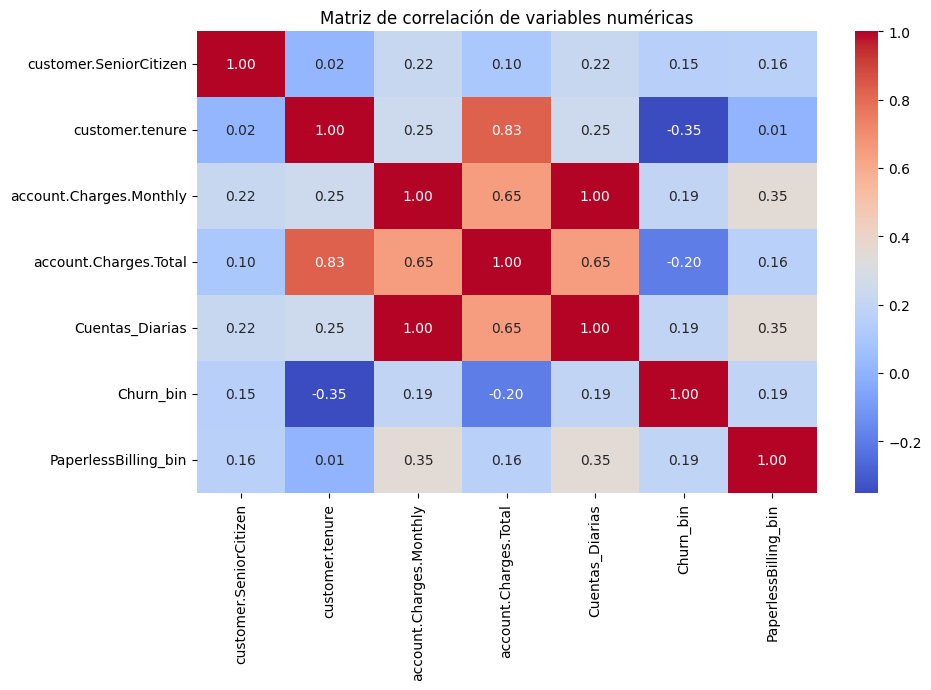

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Matriz de correlación de variables numéricas")
plt.show()


**Observaciones principales:**

- Existe una correlación negativa moderada entre `customer.tenure` y `Churn_bin`, lo que indica que los clientes con mayor antigüedad tienden a cancelar menos.
- `account.Charges.Total` también presenta correlación negativa con la cancelación, coherente con su relación directa con la antigüedad del cliente.
- El gasto mensual (`account.Charges.Monthly`) muestra una correlación positiva leve con la cancelación.
- No se observan correlaciones extremadamente altas con la variable objetivo, lo que sugiere que la cancelación depende de múltiples factores combinados.


## Análisis dirigido
Se analizan relaciones específicas entre variables clave y la cancelación de clientes para identificar patrones relevantes.


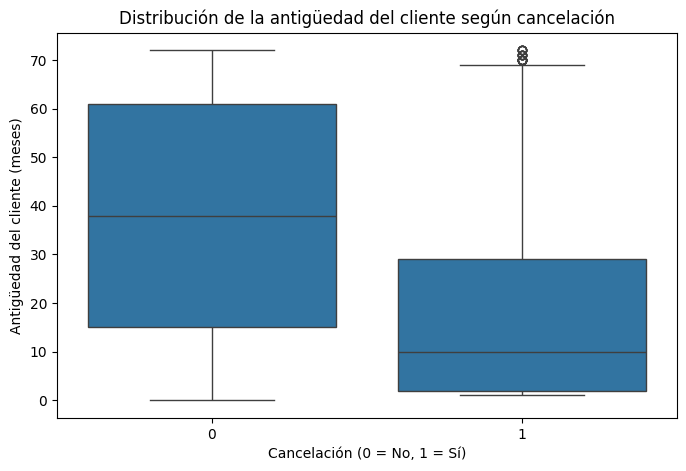

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="Churn_bin",
    y="customer.tenure",
    data=df_ml
)
plt.title("Distribución de la antigüedad del cliente según cancelación")
plt.xlabel("Cancelación (0 = No, 1 = Sí)")
plt.ylabel("Antigüedad del cliente (meses)")
plt.show()

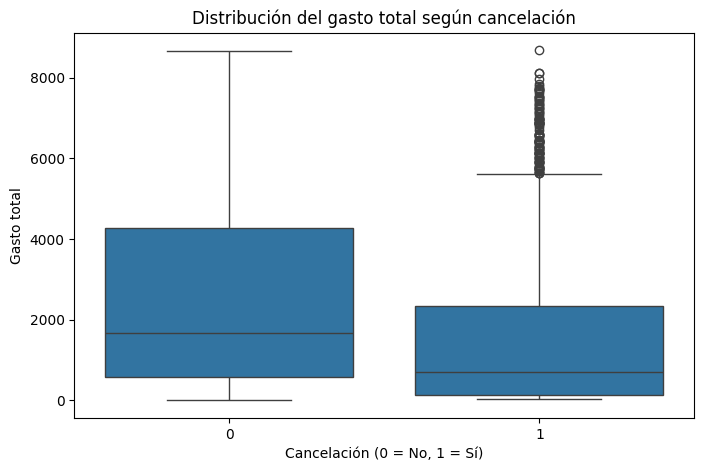

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="Churn_bin",
    y="account.Charges.Total",
    data=df_ml
)
plt.title("Distribución del gasto total según cancelación")
plt.xlabel("Cancelación (0 = No, 1 = Sí)")
plt.ylabel("Gasto total")
plt.show()

**Hallazgos principales:**

- Los clientes que cancelan el servicio presentan, en promedio, una antigüedad considerablemente menor que aquellos que permanecen activos.
- El gasto total acumulado de los clientes que cancelan es significativamente inferior, lo que refuerza la relación entre antigüedad y permanencia.
- Se observa que los clientes con mayor tiempo de contrato tienden a generar un mayor valor total y muestran menor propensión a la cancelación.


## Separación de los datos en entrenamiento y prueba
Se divide el conjunto de datos en subconjuntos de entrenamiento y prueba para evaluar la capacidad de generalización de los modelos predictivos.


In [12]:
# Defino variables predictoras y variable objetivo
X = df_ml.drop(columns=["Churn_bin"])
y = df_ml["Churn_bin"]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

## Encoding y preprocesamiento de los datos
En esta etapa se transforman las variables categóricas a formato numérico y se prepara el conjunto de datos para el entrenamiento de modelos de Machine Learning.

In [14]:
# Columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

categorical_cols, numeric_cols

(Index(['customer.gender', 'customer.Partner', 'customer.Dependents',
        'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
        'internet.OnlineSecurity', 'internet.OnlineBackup',
        'internet.DeviceProtection', 'internet.TechSupport',
        'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
        'account.PaperlessBilling', 'account.PaymentMethod'],
       dtype='object'),
 Index(['customer.SeniorCitizen', 'customer.tenure', 'account.Charges.Monthly',
        'account.Charges.Total', 'Cuentas_Diarias', 'PaperlessBilling_bin'],
       dtype='object'))

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

In [16]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape

((4930, 42), (2113, 42))

In [17]:
("cat", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), categorical_cols),
("num", "passthrough", numeric_cols)

('num',
 'passthrough',
 Index(['customer.SeniorCitizen', 'customer.tenure', 'account.Charges.Monthly',
        'account.Charges.Total', 'Cuentas_Diarias', 'PaperlessBilling_bin'],
       dtype='object'))

In [18]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape


((4930, 42), (2113, 42))

El proceso de codificación generó un conjunto de datos con 42 variables finales, combinando variables numéricas y categóricas transformadas mediante one-hot encoding.

## Creación de modelos de clasificación

In [19]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_processed, y_train)

y_pred_dummy = dummy.predict(X_test_processed)

### Modelo 1 — Árbol de Decisión

In [20]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_processed, y_train)

y_pred_dt = dt.predict(X_test_processed)

### Modelo 2 — Regresión Logística (con normalización)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_pipeline.fit(X_train, y_train)
y_pred_logreg = logreg_pipeline.predict(X_test)

## Evaluación de los modelos

In [22]:
def evaluar_modelo(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

In [23]:
resultados = {
    "Baseline (Dummy)": evaluar_modelo(y_test, y_pred_dummy),
    "Árbol de Decisión": evaluar_modelo(y_test, y_pred_dt),
    "Regresión Logística": evaluar_modelo(y_test, y_pred_logreg)
}

resultados_df = pd.DataFrame(resultados).T
resultados_df

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Accuracy,Precision,Recall,F1-score
Baseline (Dummy),0.734501,0.000000,0.000000,0.000000
Árbol de Decisión,0.728822,0.489899,0.518717,0.503896
Regresión Logística,0.796971,0.639831,0.538324,0.584705


**Conclusiones de la evaluación:**

- El modelo baseline presenta una accuracy elevada debido al desbalance de clases, pero no logra identificar clientes que cancelan.
- El Árbol de Decisión mejora significativamente la detección de churn, aunque con menor precisión.
- La Regresión Logística presenta el mejor equilibrio entre precisión y recall, obteniendo el mayor F1-score, por lo que se considera el modelo con mejor desempeño general.


### Matriz de confusión

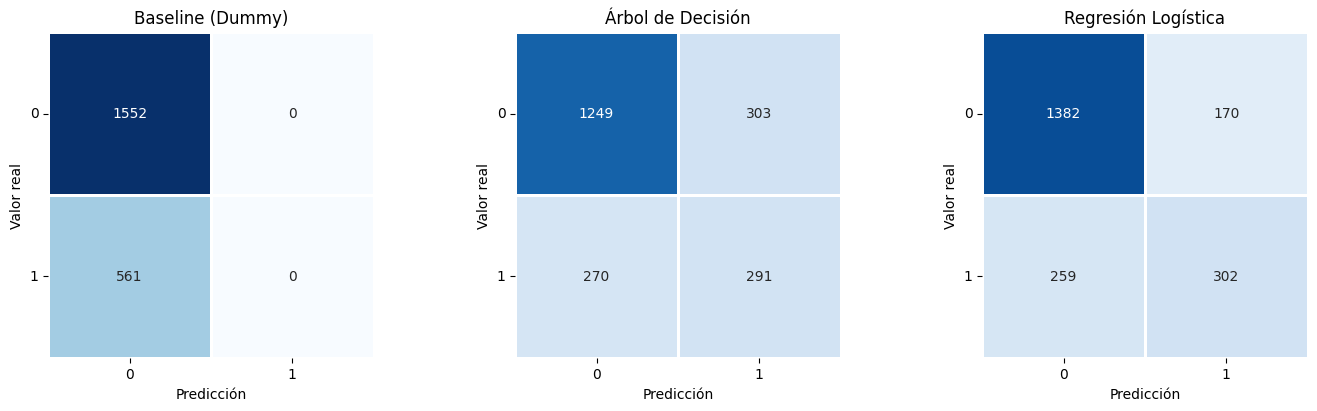

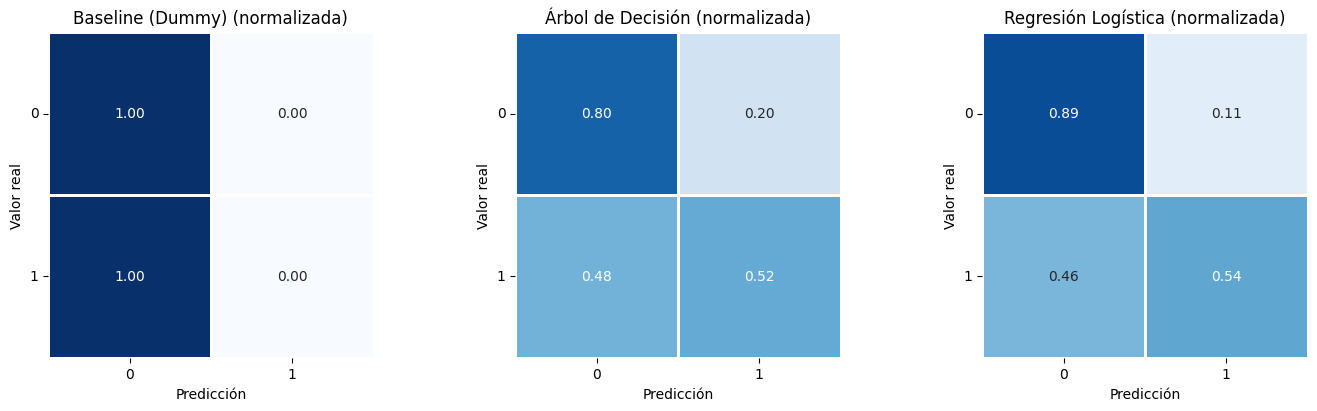

In [26]:
# --- Matrices de confusión ---
cm_dummy = confusion_matrix(y_test, y_pred_dummy)
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

cms = [cm_dummy, cm_dt, cm_logreg]
titulos = ["Baseline (Dummy)", "Árbol de Decisión", "Regresión Logística"]

# Matrices (CONTEOS ABSOLUTOS) — escala común
vmax = max(cm.max() for cm in cms)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

for ax, cm, titulo in zip(axes, cms, titulos):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        vmin=0,
        vmax=vmax,
        cbar=False,
        square=True,
        linewidths=0.8,
        linecolor="white",
        ax=ax
    )
    ax.set_title(titulo)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Valor real")
    ax.set_xticklabels(["0", "1"])
    ax.set_yticklabels(["0", "1"], rotation=0)

plt.show()

# Matrices por fila
fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

for ax, cm, titulo in zip(axes, cms, titulos):
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        vmin=0,
        vmax=1,
        cbar=False,
        square=True,
        linewidths=0.8,
        linecolor="white",
        ax=ax
    )
    ax.set_title(f"{titulo} (normalizada)")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Valor real")
    ax.set_xticklabels(["0", "1"])
    ax.set_yticklabels(["0", "1"], rotation=0)

plt.show()


Las matrices de confusión se presentan tanto en valores absolutos como normalizadas por fila para facilitar la comparación del desempeño de los modelos en la detección de cancelaciones.

## Importancia de las variables
Se analiza la contribución de las variables al modelo seleccionado para identificar los principales factores asociados a la cancelación de clientes.

In [27]:
# Obtengo los nombres de las variables luego del One-Hot Encoding
ohe = preprocessor.named_transformers_["cat"]
encoded_cat_cols = ohe.get_feature_names_out(categorical_cols)

# Unimos categóricas codificadas + numéricas
feature_names = np.concatenate([encoded_cat_cols, numeric_cols])

len(feature_names)


42

In [28]:
# Extraigo coeficientes de la regresión logística
coeficientes = logreg_pipeline.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "Variable": feature_names,
    "Coeficiente": coeficientes
})

coef_df.head()


,Variable,Coeficiente
0,customer.gender_Male,-0.086402
1,customer.Partner_Yes,-0.032902
2,customer.Dependents_Yes,-0.202550
3,phone.PhoneService_Yes,-0.220971
4,phone.MultipleLines_No,-0.246190


In [30]:
# Variables que aumentan la probabilidad de churn
top_positive = coef_df.sort_values("Coeficiente", ascending=False).head(10)
top_positive

,Variable,Coeficiente
39,account.Charges.Total,1.256297
28,account.Contract_Month-to-month,0.633932
8,internet.InternetService_Fiber optic,0.401710
34,account.PaymentMethod_Electronic check,0.245238
41,PaperlessBilling_bin,0.203393
31,account.PaperlessBilling_Yes,0.203393
19,internet.TechSupport_No,0.189754
36,customer.SeniorCitizen,0.166790
10,internet.OnlineSecurity_No,0.136302
24,internet.StreamingTV_Yes,0.108010


In [31]:
# Variables que reducen la probabilidad de cancelación
top_negative = coef_df.sort_values("Coeficiente").head(10)
top_negative



,Variable,Coeficiente
37,customer.tenure,-3.207906
30,account.Contract_Two year,-0.684750
7,internet.InternetService_DSL,-0.423110
4,phone.MultipleLines_No,-0.246190
3,phone.PhoneService_Yes,-0.220971
21,internet.TechSupport_Yes,-0.211154
2,customer.Dependents_Yes,-0.202550
33,account.PaymentMethod_Credit card (automatic),-0.199242
17,internet.DeviceProtection_No internet service,-0.157717
20,internet.TechSupport_No internet service,-0.157717


### Variables más influyentes en la cancelación

/tmp/ipython-input-884464380.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


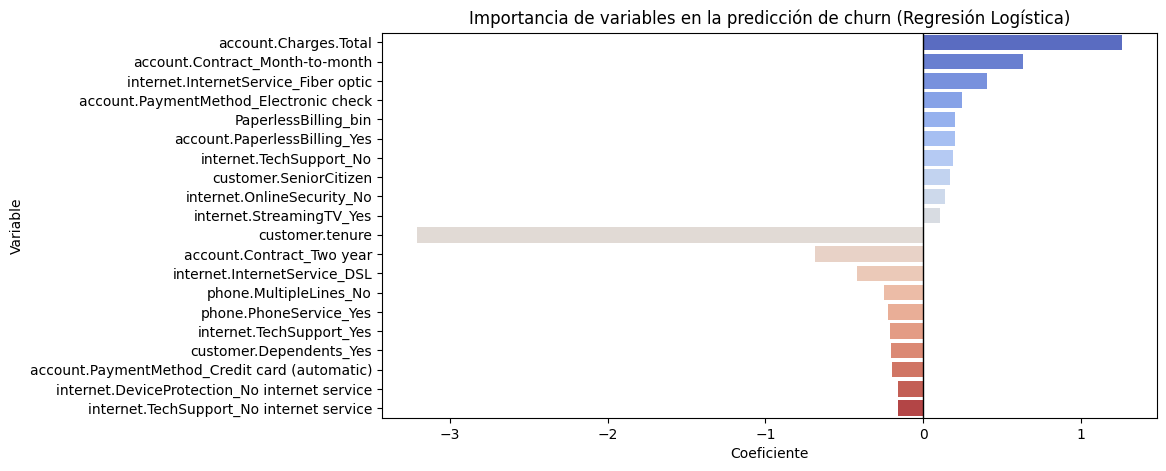

In [32]:
plt.figure(figsize=(10, 5))

sns.barplot(
    data=pd.concat([top_positive, top_negative]),
    x="Coeficiente",
    y="Variable",
    palette="coolwarm"
)

plt.title("Importancia de variables en la predicción de churn (Regresión Logística)")
plt.axvline(0, color="black", linewidth=1)
plt.show()

## Conclusión final

El presente proyecto tuvo como objetivo desarrollar un modelo predictivo capaz de identificar clientes con mayor probabilidad de cancelación (*churn*) en Telecom X, a partir de datos previamente tratados y analizados.

Luego de la preparación de los datos, el análisis exploratorio y el entrenamiento de distintos modelos de clasificación, se evaluó el desempeño de cada uno utilizando métricas adecuadas para un escenario de desbalance moderado, priorizando **recall** y **F1-score** por sobre la exactitud global.

Entre los modelos evaluados, la **Regresión Logística** presentó el mejor desempeño general, logrando el mayor F1-score y un equilibrio adecuado entre precisión y capacidad de detección de clientes que cancelan. El Árbol de Decisión mostró un desempeño aceptable y una buena capacidad de interpretación, mientras que el modelo baseline evidenció las limitaciones de utilizar únicamente métricas como la accuracy en problemas de churn.

El análisis de la importancia de las variables permitió identificar factores clave asociados a la cancelación. En particular, los clientes con **menor antigüedad**, **contratos de corto plazo** y determinadas configuraciones de servicios presentan una mayor probabilidad de cancelar. Por el contrario, una mayor permanencia, contratos más largos y una mayor vinculación con múltiples servicios se asocian con una menor propensión al churn.

Estos resultados confirman que la cancelación de clientes no depende de un único factor, sino de la combinación de variables contractuales, económicas y de relación con el servicio. En este contexto, el uso de modelos predictivos permite anticipar comportamientos de riesgo y tomar decisiones preventivas basadas en datos.

## Recomendaciones estratégicas

A partir de los hallazgos obtenidos, se sugieren las siguientes acciones para Telecom X:

- Implementar estrategias de retención temprana enfocadas en clientes con baja antigüedad, especialmente durante los primeros meses de contrato.
- Incentivar contratos de mayor duración mediante beneficios económicos o mejoras en el servicio.
- Promover la contratación de servicios combinados para aumentar el valor percibido por el cliente.
- Integrar el modelo predictivo como un sistema de **alerta temprana**, permitiendo priorizar acciones comerciales y de atención al cliente de manera más eficiente.

La adopción de este enfoque permitiría a Telecom X reducir la tasa de cancelación y optimizar sus recursos mediante decisiones estratégicas sustentadas en análisis de datos y modelos de Machine Learning.

### Consideración sobre modelos alternativos

Si bien modelos basados en distancia como **K-Nearest Neighbors (KNN)** pueden ser utilizados en problemas de clasificación, en este proyecto se priorizaron modelos con mayor capacidad de interpretación y mejor desempeño en espacios de alta dimensionalidad. Dado el número de variables resultantes tras el proceso de codificación y el tamaño del conjunto de datos, se consideró que modelos como la Regresión Logística y los basados en árboles ofrecían una mejor relación entre desempeño predictivo, interpretabilidad y aplicabilidad a decisiones de negocio.